# Load diagnosis records from pakistan

In [21]:
import pandas as pd
column_names = ['id', 'gender', 'age', 'height', 'weight', 'symptoms', 'diagnosis']
records = pd.DataFrame(columns =  column_names, )
print(records)
f = open('Pakistan_records.txt')
line = f.readline()
while line:
    if 'contents' in line: 
        line = f.readline()
    line = line.strip().strip('I\/System.out: ')
    
    info = list(line.split(';'))
    temp = pd.Series(dict(zip(column_names, info))) 
    records = records.append(temp, ignore_index=True)
    
    line = f.readline()  
f.close()

Empty DataFrame
Columns: [id, gender, age, height, weight, symptoms, diagnosis]
Index: []


# cleanning the data

In [22]:
records = records[records['id'] != '0']
records.drop_duplicates(inplace=True)
records.dropna(inplace=True)
records.reset_index(drop=True, inplace=True)

In [3]:
records.to_csv('records_clean.csv')

# compare the predicted diagnosis with the doctors

In [4]:
WM = pd.read_csv('DiseaseSymptomMatrix_quantitative.csv', index_col = 0)
WM.reset_index(drop=True, inplace=True)
WM.columns = list(range(len(WM.columns)))

In [5]:
T = 0.03
import numpy as np
def renorm(dia):
    dia.sort_values(ascending=False, inplace=True)
    dia.reset_index(drop=True)
    s = sum([np.exp(ai/T) for ai in dia])
    return np.exp(dia/T)/s

In [6]:
def SelectedMatrix(sym):
    selected = WM[WM[sym] != 0]
    selected.drop(sym, axis=1, inplace=True)
    for c in selected.columns:
        if sum(selected[c]) == 0:
            selected.drop(c, axis=1, inplace=True)
    return selected
    

In [7]:
#np = 5
np = 10
def diag(symptoms, disease):
    sym = symptoms[0]
        
    selected = SelectedMatrix(sym)
    
    #The response vector
    res = pd.Series(index=WM.columns, data=[0]*len(WM.columns))
    res[sym] = 1
    
    while True:
        # compute the probabilities
        dia = WM.dot(res)
        
        # drop the columns with no information
        for j in selected.columns:
            if 0 not in selected[j].value_counts():
                res[j] = 1
                selected.drop(columns=[j], inplace = True)  
        
        # the diagnosis criterion
        if len(selected) == 1:
            #dia = renorm(dia)
            dia.sort_values(ascending=False, inplace=True)
            #return dia.keys()[:np]
            cnt = 0
            while dia.keys()[cnt] != disease:
                cnt += 1
            return cnt
            
        #choose the most relevant symptom to ask: The symptom that are least shared with other diseases
        next_i = selected.columns[0]
        s = 100
        for i in selected.columns:   
            if 0 in selected[i].value_counts():
                pri = abs(selected[i].value_counts()[0] - len(selected)/2)
                if pri < s:
                    s = pri
                    next_i = i      
            else:
                res[next_i] = 1
                selected = selected[selected[next_i]!=0]
         
        
        if next_i in symptoms:
            res[next_i] = 1
            selected = selected[selected[next_i]!=0]
        else:
            res[next_i] = 0
            selected = selected[selected[next_i]==0]
            
        selected.drop(columns=[next_i], inplace = True)

In [8]:
diag([366], 115)

C:\Users\zhang\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


0

In [9]:
for i in records.index:
    s = records.loc[i, 'symptoms']
    l = list(map(int, s.split(',')))
    d = int(records.loc[i,'diagnosis'])
    records.loc[i, 'n_acc'] = str(diag(l,d))

In [10]:
records.head()

,id,gender,age,height,weight,symptoms,diagnosis,n_acc
0,2,F,35,170.0,75.0,366,115,0
1,5520,F,49,-1.0,65.0,"358,2,105,6,16,3",5,0
2,1257,M,60,-1.0,70.0,"145,142,476,249,141,5",20,68
3,5234,F,55,-1.0,65.0,"43,527,141,74",55,1
4,5235,F,55,-1.0,65.0,"145,420,358,524,1",131,131


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
x = list(range(165))
y = [0]*165
for i in records.index:
    y[int(records.loc[i,'n_acc'])] += 1
plt.bar(x = x, height=y)

<BarContainer object of 165 artists>

<BarContainer object of 5 artists>

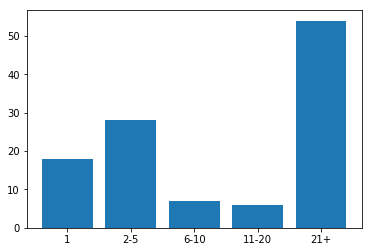

In [17]:
x1 = ['1', '2-5', '6-10', '11-20', '21+']
y1 = [y[0], sum(y[1:7]), sum(y[7:12]), sum(y[12:22]), sum(y[22:])]
plt.bar(x=x1, height=y1)

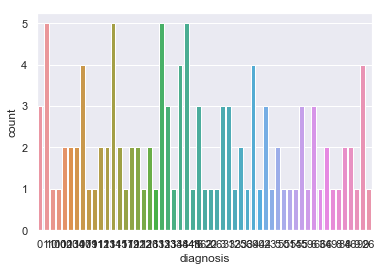

In [20]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(records.diagnosis)

In [3]:
import pandas as pd
records=pd.read_csv('records_clean.csv',index_col=0)
records

,id,gender,age,height,weight,symptoms,diagnosis
0,2,F,35,170.0,75.0,366,115
1,5520,F,49,-1.0,65.0,"358,2,105,6,16,3",5
2,1257,M,60,-1.0,70.0,"145,142,476,249,141,5",20
3,5234,F,55,-1.0,65.0,"43,527,141,74",55
4,5235,F,55,-1.0,65.0,"145,420,358,524,1",131
5,5931,F,60,-1.0,66.0,"88,231,59",148
6,3214,F,66,-1.0,60.0,"145,420,358,110,430",132
7,3697,M,44,-1.0,77.0,249,8
8,6066,M,40,-1.0,70.0,"524,10,388,0,139,0",3
9,2435,F,24,-1.0,50.0,"138,60,1",144


In [4]:
count = 0
for i in records.index:
    if records.loc[i, 'diagnosis'] in records.loc[i, 'predicted_10']:
        count += 1
print(count)

KeyError: 'the label [predicted_10] is not in the [index]'

In [25]:
i=0
print(records.loc[i, 'diagnosis'])
print(records.loc[i, 'predicted'])


115
[115, 164, 51, 58, 57]


In [ ]:
145,142,476,249,141,5	20	[35, 133, 21, 25, 38]

In [43]:
for i in [20,133, 21, 35, 25, 38]:
    s = WM.loc[i, 145] + WM.loc[i, 142] + WM.loc[i, 476] + WM.loc[i, 249] + WM.loc[i, 141] + WM.loc[i, 5]
    print(s)

0.12600094921728766
0.16747117294577432
0.16456007405293854
0.34706116144154486
0.1449006210605796
0.12610207512723187


In [11]:
records.head()

,id,gender,age,height,weight,symptoms,diagnosis
0,2,F,35,170.0,75.0,366,115
1,5520,F,49,-1.0,65.0,"358,2,105,6,16,3",5
2,1257,M,60,-1.0,70.0,"145,142,476,249,141,5",20
3,5234,F,55,-1.0,65.0,"43,527,141,74",55
4,5235,F,55,-1.0,65.0,"145,420,358,524,1",131


In [5]:
records['age_int'] = pd.Series(map(int, records['age']))
records['age'] = records['age_int']
records.boxplot(column='age', by='gender', grid = False, fontsize=12)

In [6]:
len(set(records['id']))

88

In [7]:
s = set()
for i in records.index:
    tup = (records.loc[i, 'id'], records.loc[i,'gender'])
    s.add(tup)
    
print(len(s))

99


In [33]:
m = 0
f = 0
for t in s:
    if t[1] == 'M':
        m += 1
    if t[1] == 'F':
        f += 1
print(m, f)

46 53


In [9]:
import numpy as np
X1 = []

for s in records.symptoms:
    symps = list(map(int, s.split(',')))
    X1.append(symps)
    
X = np.zeros((len(X1), 584))

for i in range(len(X1)):
    for j in X1[i]:
        X[i,j] = 1
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [10]:
WM = pd.read_csv('DiseaseSymptomMatrix_quantitative.csv', index_col = 0)

In [11]:
import numpy as np
np.ndarray((2, 3))

array([[6.42e-323, 1.28e-322, 1.93e-322],
       [6.92e-323, 1.33e-322, 1.98e-322]])

In [12]:
WM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, I10 to I50
Columns: 584 entries, C0008031 to C2111963
dtypes: float64(584)
memory usage: 754.1+ KB


In [13]:
w = np.transpose(WM.values)

In [14]:
w.shape

(584, 165)

In [15]:
X.shape

(113, 584)

In [16]:
X.dot(w)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31472974, 0.34561102, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11710547, 0.        , 0.04761905, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.10612083, 0.        , 0.04761905, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11002623, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01582726, 0.01511362, 0.        , ..., 0.        , 0.        ,
        0.00489505]])

In [17]:
y = [np.argmax(line) for line in X.dot(w)]

In [18]:
res = []
y = X.dot(w)
for i in records.index:
    d = int(records.loc[i,'diagnosis'])
    tmp = 0
    for v in y[i]:
        if v>y[i][d]:
            tmp += 1
    print(tmp)
    res.append(tmp)
    

0
1
7
1
0
3
3
1
0
27
29
1
0
15
13
4
2
3
4
50
3
2
3
0
4
2
2
2
14
13
3
35
15
14
4
4
27
5
15
12
5
0
0
4
1
4
26
0
0
1
58
2
0
4
0
2
4
1
3
1
0
2
0
3
33
5
35
53
4
20
0
2
0
56
70
1
0
0
3
0
13
2
11
37
0
8
4
68
0
3
0
52
2
8
0
3
3
3
0
3
1
6
13
0
1
0
1
4
47
0
0
17
1


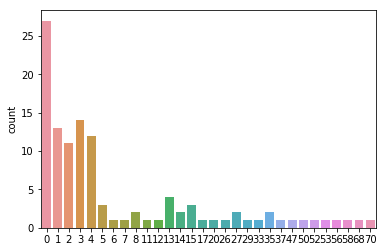

In [19]:
import seaborn as sns
sns.countplot(res)

In [20]:
records.describe()

,id,age,height,weight,diagnosis,age_int
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,449.309735,39.292035,0.513274,61.362832,76.946903,39.292035
std,1281.358773,10.655885,16.086327,8.888257,49.291741,10.655885
min,1.000000,10.000000,-1.000000,25.000000,0.000000,10.000000
25%,24.000000,33.000000,-1.000000,60.000000,35.000000,33.000000
50%,69.000000,39.000000,-1.000000,60.000000,92.000000,39.000000
75%,89.000000,44.000000,-1.000000,69.000000,117.000000,44.000000
max,6066.000000,69.000000,170.000000,80.000000,162.000000,69.000000


In [22]:
top1 = 0
top5 = 0
for i in res:
    if i==0:
        top1+=1
    if i<5:
        top5+=1
print(top1, top5)

27 77


In [23]:
len(res)

113